# TinyML Seminar — Quantization Hands-On (PyTorch)

> Welcome! In this guided workshop we’ll make neural networks smaller and faster by turning floats into efficient integers—without throwing accuracy out the window. 

- Outcomes you can expect:
  1) Explain what uniform affine quantization is (scale, zero-point).
  2) Run PTQ (static & dynamic) and QAT on a small CNN.
  3) Compare accuracy/latency/size and discuss trade-offs (clipping, per-channel, activations).
  4) Extend to a custom STE-based quantizer.

Tip: If you’re short on time or CPU, set FAST_MODE = True in the next cell to cap epochs and batches.

## 0. Setup & Environment

- You’ll need: `torch`, `torchvision`, `matplotlib`, `numpy`.
- This notebook runs on CPU; GPU will be used for FP32 training if available. Quantized kernels run on CPU.
- First run may download CIFAR-10 and (optionally) MobileNetV2 pretrained weights.

Practical tips:
- If the machine is slow, turn on FAST_MODE (next cell).

In [1]:

# %pip install --quiet torch torchvision matplotlib numpy

import os, math, time, copy, warnings
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms, models

# Quantization APIs (PyTorch 1.13+/2.x use torch.ao.quantization)
from torch.ao.quantization import (
    get_default_qconfig, get_default_qat_qconfig,
    prepare, prepare_qat, convert, fuse_modules, quantize_dynamic
)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Demo-speed controls
FAST_MODE = False      # set False for more thorough training/eval
EPOCHS = 3 if FAST_MODE else 5
TRAIN_BATCHES = 60 if FAST_MODE else None     # limit number of train batches per epoch
TEST_BATCHES = 40 if FAST_MODE else None      # limit number of test batches
CALIBRATION_BATCHES = 20 if FAST_MODE else 100


Using device: cuda



### Utility Helpers
- Accuracy & latency evaluation
- Model size reporting
- Weight histogram plotting
- Subset loaders (for speed)


In [3]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def save_size_mb(state_dict_path: str) -> float:
    return os.path.getsize(state_dict_path) / 1e6 if os.path.exists(state_dict_path) else float('nan')

@torch.no_grad()
def evaluate(model, loader, max_batches=None, measure_latency=True):
    model.eval()
    correct, total = 0, 0
    latencies = []
    n_batches = 0
    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break
        start = time.time() if measure_latency else None
        out = model(x.to(device))
        if measure_latency:
            torch.cuda.synchronize() if device.type == "cuda" else None
            latencies.append((time.time() - start) * 1000.0)
        pred = out.argmax(dim=1).cpu()
        correct += (pred == y).sum().item()
        total += y.size(0)
        n_batches += 1
    acc = 100.0 * correct / max(1, total)
    lat = float(np.mean(latencies)) if (measure_latency and latencies) else float('nan')
    return acc, lat, n_batches

def plot_weight_histograms(model, title="Weight Histograms", layers_to_show=None, bins=80):
    figs = []
    with torch.no_grad():
        params = [(n, p.detach().cpu().view(-1)) for n, p in model.named_parameters() if "weight" in n]
        if layers_to_show:
            params = [t for t in params if any(key in t[0] for key in layers_to_show)]
        cols = 2
        rows = math.ceil(len(params) / cols) if params else 1
        fig, axes = plt.subplots(rows, cols, figsize=(10, 4*rows))
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
        for ax, (name, data) in zip(axes, params):
            ax.hist(data.numpy(), bins=bins)
            ax.set_title(name)
        for j in range(len(params), len(axes)):
            axes[j].axis('off')
        fig.suptitle(title)
        plt.tight_layout()
        figs.append(fig)
    return figs

def print_results_table(rows, headers=("Model","Type","Accuracy_%","Latency_ms","Size_MB","Params_M")):
    # Pretty print a table
    col_widths = [max(len(str(x)) for x in [h]+[r[i] for r in rows]) for i,h in enumerate(headers)]
    fmt = " | ".join("{:<" + str(w) + "}" for w in col_widths)
    print(fmt.format(*headers))
    print("-+-".join("-"*w for w in col_widths))
    for r in rows:
        print(fmt.format(*r))

def subset_loader(loader, max_batches=None):
    if max_batches is None:
        return loader
    indices = []
    seen = 0
    for i, _ in enumerate(loader):
        if i >= max_batches:
            break
        batch_indices = range(i*loader.batch_size, min((i+1)*loader.batch_size, len(loader.dataset)))
        indices.extend(batch_indices)
        seen += 1
    if not indices:
        return loader
    subset_ds = Subset(loader.dataset, indices)
    return DataLoader(subset_ds, batch_size=loader.batch_size, shuffle=False, num_workers=0)



---
# Module 1 — Quantization Visualization

**Goal:** Visualize discretization and quantization error.


## Quantization: Why, What, and How

> Goal: reduce model size and compute cost by representing tensors with low-precision integers while keeping accuracy high.

- Why it matters:
  - Smaller models (INT8 is 4x smaller than FP32), faster memory bandwidth, lower power.
  - Integer MACs are cheaper than floating-point on many CPUs/MCUs/NPUs.

- The core mapping (uniform affine quantization):
  - Choose integer range: for signed INT8, $q \in [-128, 127]$; for UINT8, $q \in [0, 255]$.
  - Pick a floating-point range $[\alpha, \beta]$ that the tensor should cover (from calibration or stats).
  - Compute scale $s$ and zero-point $z$; map floats $x$ to ints $q$ and back:

    $$
    q = \operatorname{clip}\big( \operatorname{round}(x/s) + z,\ q_{\min},\ q_{\max} \big)
    $$

    $$
    \hat{x} = (q - z)\, s
    $$

  - Choices:
    - symmetric: $z = 0$ (common for weights), often signed INT8.
    - asymmetric: $z \ne 0$ (common for activations), often UINT8. A typical choice maps $\alpha$ to $q_{\min}$:

      $$
      z = \operatorname{round}\!\left( q_{\min} - \frac{\alpha}{s} \right)\ \ \text{clamped to}\ [q_{\min},\ q_{\max}]
      $$

    - per-tensor (one $s,z$ per tensor) vs per-channel (one $s,z$ per output channel).

- Bits and resolution:

  $$
  L = 2^b,\quad \Delta = \frac{\beta - \alpha}{L - 1},\quad e = x - \hat{x},\quad |e| \le \tfrac{\Delta}{2}\ \text{(inside range)}
  $$

- Error and quick theory checks:

  $$
  \mathrm{MSE} \approx \frac{\Delta^2}{12}\quad \text{(uniform, high-resolution)}
  $$

  $$
  \mathrm{SNR}_{\mathrm{dB}} \approx 6.02\,b + 1.76\quad \text{(full-scale sine)}
  $$

  - Outliers are expensive: a few large values can force a huge range (large $\Delta$) \Rightarrow larger error overall.
  - Clipping is a trade-off: reduce range to get smaller $\Delta$ (better for most points) but clip the outliers.

Below, we’ll visualize:
1) The staircase mapping and dequant centers.
2) A sine wave quantized at different bit-widths, with empirical MSE vs. $\Delta^2/12$.
3) A clipping sweep to show the range–error trade-off.

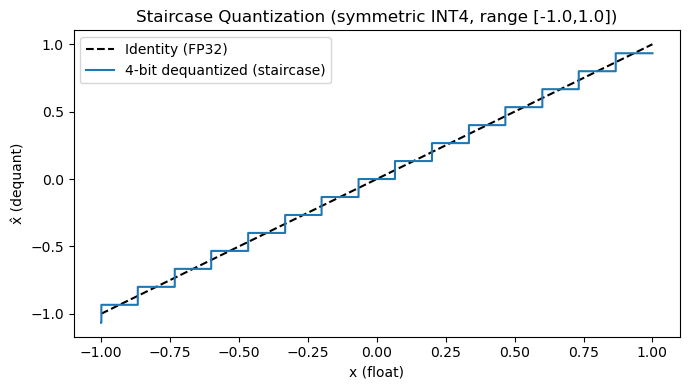

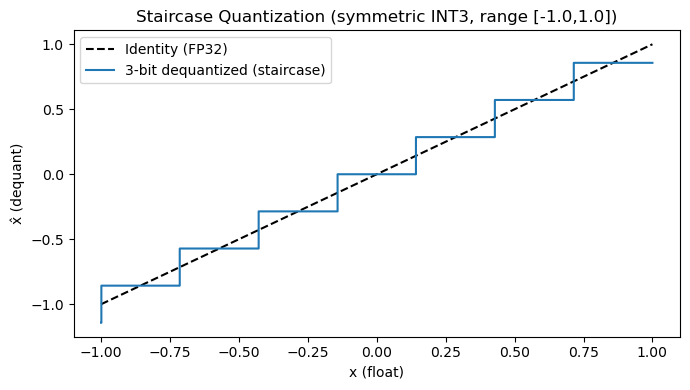

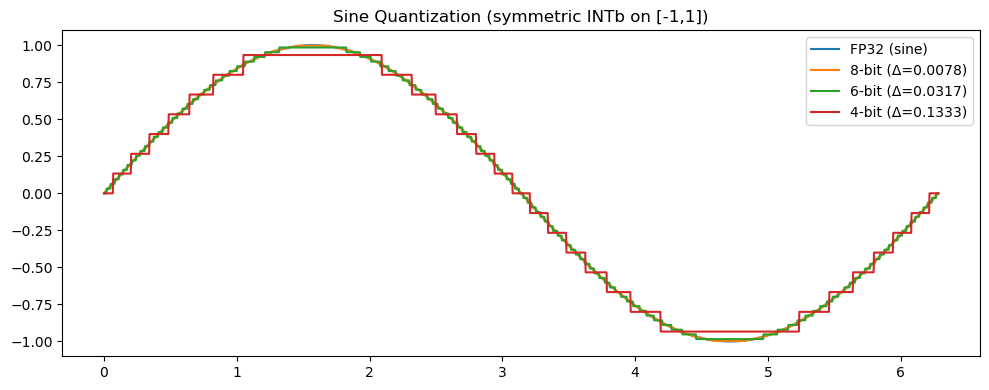

MSE vs theory (Δ^2/12) for sine on [-1,1]:
   8-bit: MSE_emp=5.277001e-06,  MSE_theory≈5.126233e-06
   6-bit: MSE_emp=8.943871e-05,  MSE_theory≈8.398421e-05
   4-bit: MSE_emp=1.678794e-03,  MSE_theory≈1.481481e-03
   3-bit: MSE_emp=8.127050e-03,  MSE_theory≈6.802721e-03


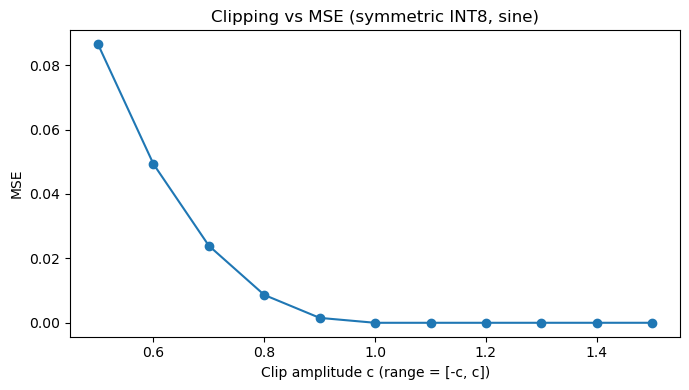

In [4]:
# Pedagogical quantization demo: affine mapping, staircase, error, and clipping
import numpy as np
import matplotlib.pyplot as plt

# Core affine quantization utilities
def affine_params(alpha, beta, bits=8, signed=True):
    L = 2**bits
    if signed:
        qmin, qmax = -(L//2), L//2 - 1   # e.g., INT8: -128..127
    else:
        qmin, qmax = 0, L - 1            # e.g., UINT8: 0..255
    # Avoid degenerate range
    if beta <= alpha:
        beta = alpha + 1e-6
    s = (beta - alpha) / (qmax - qmin)
    # For symmetric: force zero-point ≈ 0; for asymmetric: map alpha→qmin
    if signed:
        z = 0
    else:
        z = int(round(qmin - alpha / s))
        z = max(qmin, min(qmax, z))
    return s, z, (qmin, qmax)

def quantize(x, s, z, qmin, qmax):
    q = np.round(x / s + z)
    q = np.clip(q, qmin, qmax)
    return q.astype(np.int32)

def dequantize(q, s, z):
    return (q - z) * s

# 1) Staircase mapping visualization on a small range
alpha, beta = -1.0, 1.0
xs = np.linspace(alpha, beta, 1000)
for bits in [4, 3]:
    s, z, (qmin, qmax) = affine_params(alpha, beta, bits=bits, signed=True)
    q = quantize(xs, s, z, qmin, qmax)
    xh = dequantize(q, s, z)
    plt.figure(figsize=(7,4))
    plt.plot(xs, xs, 'k--', label='Identity (FP32)')
    plt.step(xs, xh, where='mid', label=f'{bits}-bit dequantized (staircase)')
    plt.title(f'Staircase Quantization (symmetric INT{bits}, range [{alpha},{beta}])')
    plt.xlabel('x (float)'); plt.ylabel("x̂ (dequant)")
    plt.legend(); plt.tight_layout(); plt.show()

# 2) Sine wave demo + error vs theory
x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)  # amplitude 1
plt.figure(figsize=(10,4))
plt.plot(x, y, label='FP32 (sine)')
for bits in [8, 6, 4]:
    s, z, (qmin, qmax) = affine_params(-1.0, 1.0, bits=bits, signed=True)
    yq = dequantize(quantize(y, s, z, qmin, qmax), s, z)
    plt.plot(x, yq, label=f'{bits}-bit (Δ={(2.0)/(2**bits - 1):.4f})')
plt.title('Sine Quantization (symmetric INTb on [-1,1])')
plt.legend(); plt.tight_layout(); plt.show()

# Empirical MSE vs high-resolution theory (Δ^2/12)
print('MSE vs theory (Δ^2/12) for sine on [-1,1]:')
for bits in [8, 6, 4, 3]:
    s, z, (qmin, qmax) = affine_params(-1.0, 1.0, bits=bits, signed=True)
    yq = dequantize(quantize(y, s, z, qmin, qmax), s, z)
    err = y - yq
    mse_emp = float(np.mean(err**2))
    Delta = (2.0) / (2**bits - 1)
    mse_theory = (Delta**2)/12.0
    print(f'  {bits:>2}-bit: MSE_emp={mse_emp:.6e},  MSE_theory≈{mse_theory:.6e}')

# 3) Clipping trade-off: sweep clip bounds and measure MSE
clips = np.linspace(0.5, 1.5, 11)  # clip symmetric at ±c
mse_list = []
for c in clips:
    s, z, (qmin, qmax) = affine_params(-c, c, bits=8, signed=True)
    yq = dequantize(quantize(y, s, z, qmin, qmax), s, z)
    mse_list.append(np.mean((y - yq)**2))
plt.figure(figsize=(7,4))
plt.plot(clips, mse_list, marker='o')
plt.title('Clipping vs MSE (symmetric INT8, sine)')
plt.xlabel('Clip amplitude c (range = [-c, c])'); plt.ylabel('MSE')
plt.tight_layout(); plt.show()

---
# Module 2 — DNN Primer (CIFAR-10 + Small CNN + MobileNetV2)

> Objective: train a compact CNN you can fully inspect, and bring in a larger reference model for contrast.

What we’ll do:
- Load CIFAR-10 with minimal transforms.
- Implement a small, quantization-friendly CNN (fusable Conv+ReLU blocks).
- Train briefly and log accuracy/latency/size.
- Load MobileNetV2 to compare parameter counts and sizes.

In [6]:

# Data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

data_root = "./data"
train_ds = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_train)
test_ds = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2)

print("Train size:", len(train_ds), "Test size:", len(test_ds))


100%|██████████| 170498071/170498071 [00:09<00:00, 18887879.30it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train size: 50000 Test size: 10000


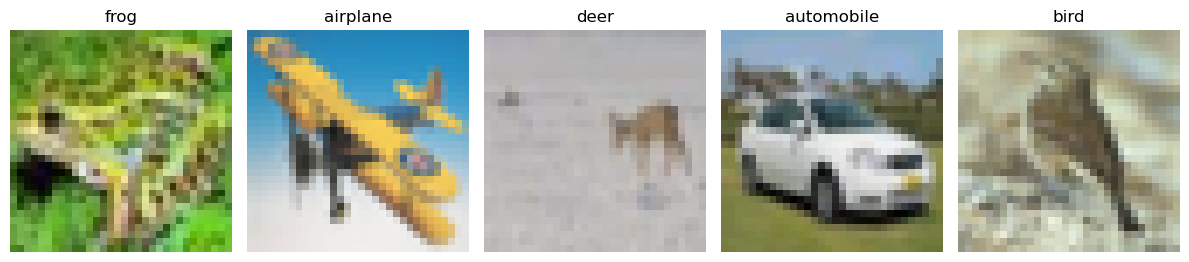

In [7]:
# Peek at a few CIFAR-10 images (5 samples)
imgs, lbls = next(iter(train_loader))
classes = getattr(train_ds, 'classes', [str(i) for i in range(10)])
n = min(5, imgs.size(0))
plt.figure(figsize=(12, 3))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    img = imgs[i].permute(1, 2, 0).numpy()  # CHW -> HWC
    plt.imshow(np.clip(img, 0, 1))
    title = classes[lbls[i].item()] if lbls[i].item() < len(classes) else str(lbls[i].item())
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:

# Small CNN — quantization-friendly (with fuse-able patterns and Quant/DeQuant stubs)

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Features
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2)  # 16x16
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2)  # 8x8
        
        # Classifier
        self.fc1 = nn.Linear(64*8*8, 256)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Quant stubs for static quantization/QAT
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()
        
    def fuse_model(self):
        # Fuse Conv+ReLU pairs for quantization improvements
        fuse_modules(self, [["conv1","relu1"], ["conv2","relu2"]], inplace=True)
        # Note: we keep relu3 separate (linear+relu fusion is not standard in PyTorch)
        
    def forward(self, x):
        # Stubs for quant-aware paths; in FP32 they are identity
        x = self.quant(x)
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        x = self.dequant(x)
        return x

model_fp32 = SmallCNN().to(device)
print(model_fp32)
print("Params (M):", round(count_parameters(model_fp32)/1e6, 3))


SmallCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (relu3): ReLU(inplace=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)
Params (M): 1.071


In [9]:

def train_one_epoch(model, loader, optimizer, criterion, max_batches=None):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / max(1, (i+1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_fp32.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    loss = train_one_epoch(model_fp32, train_loader, optimizer, criterion, max_batches=TRAIN_BATCHES)
    acc, lat, _ = evaluate(model_fp32, test_loader, max_batches=TEST_BATCHES)
    print(f"[FP32][Epoch {epoch+1}/{EPOCHS}] loss={loss:.4f} acc={acc:.2f}% latency={lat:.2f} ms")

os.makedirs("artifacts", exist_ok=True)
torch.save(model_fp32.state_dict(), "artifacts/smallcnn_fp32.pt")
print("SmallCNN FP32 size (MB):", save_size_mb("artifacts/smallcnn_fp32.pt"))


[FP32][Epoch 1/5] loss=1.4860 acc=56.86% latency=11.67 ms
[FP32][Epoch 2/5] loss=1.1246 acc=62.02% latency=9.51 ms
[FP32][Epoch 3/5] loss=0.9746 acc=66.31% latency=9.93 ms
[FP32][Epoch 4/5] loss=0.8800 acc=68.74% latency=6.67 ms
[FP32][Epoch 5/5] loss=0.8115 acc=69.90% latency=11.74 ms
SmallCNN FP32 size (MB): 4.2866


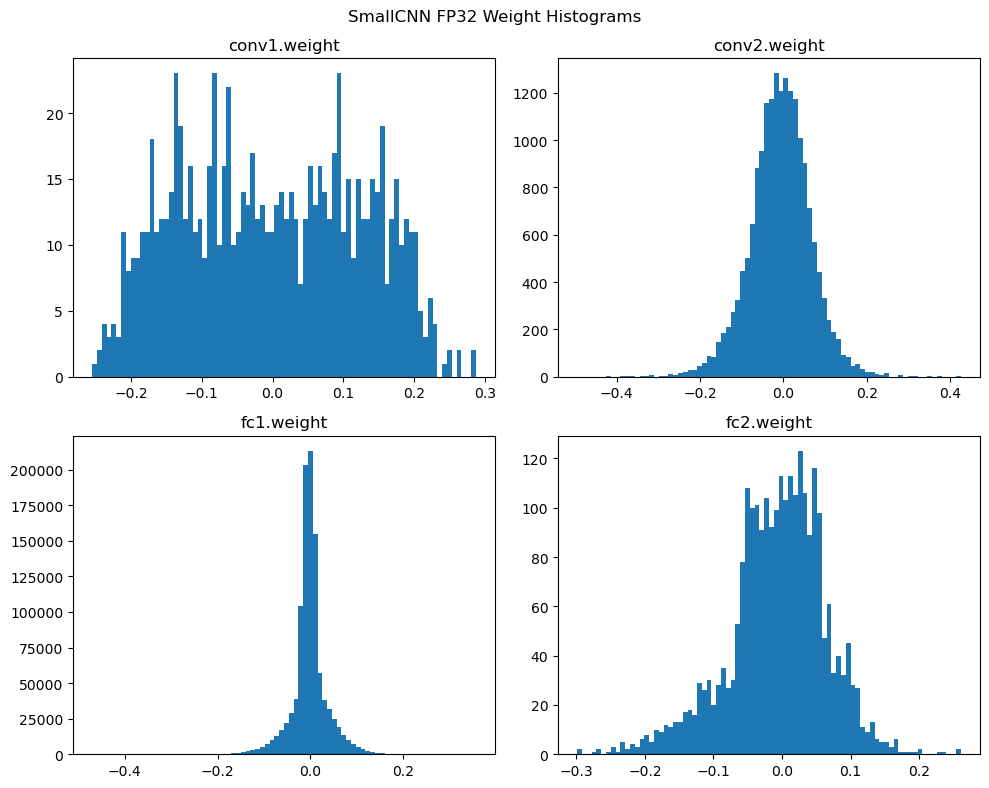

In [10]:

# Visualize weights (conv and fc)
_ = plot_weight_histograms(model_fp32, title="SmallCNN FP32 Weight Histograms",
                           layers_to_show=["conv1", "conv2", "fc1", "fc2"])
plt.show()


In [11]:

# Load MobileNetV2 pretrained (fallback to randomly initialized if offline)
try:
    mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    print("Loaded MobileNetV2 with pretrained weights.")
except Exception as e:
    warnings.warn(f"Could not load pretrained weights ({e}). Falling back to randomly initialized MobileNetV2.")
    mobilenet = models.mobilenet_v2(weights=None)

mobilenet.classifier[-1] = nn.Linear(mobilenet.last_channel, 10)  # adapt head for CIFAR-10 (untrained)
mobilenet.eval()
torch.save(mobilenet.state_dict(), "artifacts/mobilenetv2_fp32.pt")
print("MobileNetV2 FP32 size (MB):", save_size_mb("artifacts/mobilenetv2_fp32.pt"))


Loaded MobileNetV2 with pretrained weights.
MobileNetV2 FP32 size (MB): 9.18942


### Fine-tuning MobileNetV2 for CIFAR-10
- The pretrained weights are ImageNet (1000 classes). We’ve already swapped the head to 10 classes, but it needs fine-tuning.
- For this seminar, we’ll first try to load a pre-finetuned checkpoint if it’s available locally; otherwise we’ll run a brief fine-tune now and save it for reuse.


What we apply:
- Resize CIFAR-10 to 224×224 and normalize with ImageNet stats.
- Staged training: head-only warmup, then unfreeze several final inverted residual blocks.
- Optimizer: SGD + momentum + weight decay (often better for CNN transfer).
- Cosine LR schedule with head vs. backbone LR decoupling.
- Light regularization/augmentation: RandomResizedCrop, HorizontalFlip, optional AutoAugment, Mixup, Label smoothing.
- Partial unfreeze (last K blocks) keeps earlier generic features stable while adapting higher-level features to CIFAR-10.

You can tune: number of blocks to unfreeze, mixup alpha, total epochs, and learning rates.

In [16]:
# MobileNetV2 CIFAR-10 loaders (ImageNet-sized & normalized)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# More aggressive augmentation can be toggled via USE_AUTOAUG or MIXUP settings
USE_AUTOAUG = False
MIXUP_ALPHA = 0.2  # set 0.0 to disable
LABEL_SMOOTH = 0.1

mbnet_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    *( [transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10)] if USE_AUTOAUG else [] ),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

mbnet_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

mbnet_train_ds = datasets.CIFAR10(root=data_root, train=True, download=True, transform=mbnet_train_transform)
mbnet_test_ds  = datasets.CIFAR10(root=data_root, train=False, download=True, transform=mbnet_test_transform)

mbnet_train_loader = DataLoader(mbnet_train_ds, batch_size=128, shuffle=True,  num_workers=2)
mbnet_test_loader  = DataLoader(mbnet_test_ds,  batch_size=256, shuffle=False, num_workers=2)
print('MobileNetV2 loaders ready (train/test sizes):', len(mbnet_train_ds), len(mbnet_test_ds))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
MobileNetV2 loaders ready (train/test sizes): 50000 10000
MobileNetV2 loaders ready (train/test sizes): 50000 10000


In [ ]:
# Enhanced fine-tuning utilities (staged unfreeze + mixup + cosine LR)
def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

def mixup_batch(x, y, alpha=0.2, num_classes=10):
    if alpha is None or alpha <= 0.0:
        return x, y, None
    lam = np.random.beta(alpha, alpha)
    perm = torch.randperm(x.size(0))
    x_mix = lam * x + (1 - lam) * x[perm]
    y_one = F.one_hot(y, num_classes=num_classes).float()
    y_mix = lam * y_one + (1 - lam) * y_one[perm]
    return x_mix, y_mix, lam

def soft_target_loss(logits, soft_targets):
    return -(soft_targets * F.log_softmax(logits, dim=1)).sum(dim=1).mean()

@torch.no_grad()
def evaluate_mbnet(model, loader, max_batches=None):
    model.eval()
    correct, total = 0, 0
    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break
        out = model(x.to(device))
        pred = out.argmax(1).cpu()
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / max(1,total)

def fine_tune_mobilenet_v2(model, train_loader, test_loader,
                            epochs_head=5, epochs_stage2=15, unfreeze_last_blocks=4,
                            head_lr=0.01, backbone_lr=0.001, momentum=0.9, weight_decay=4e-5,
                            mixup_alpha=0.2, label_smoothing=0.1, num_classes=10,
                            fast_mode=FAST_MODE):
    # Adjust epochs if FAST_MODE
    if fast_mode:
        epochs_head = 1
        epochs_stage2 = 3
    model = model.to(device)
    # 1) Head-only phase
    set_requires_grad(model.features, False)
    set_requires_grad(model.classifier, True)
    optimizer = torch.optim.SGD(model.classifier.parameters(), lr=head_lr, momentum=momentum, weight_decay=weight_decay)
    criterion_head = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    history = []
    for ep in range(epochs_head):
        model.train()
        running = 0.0
        for i,(x,y) in enumerate(train_loader):
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            if mixup_alpha>0:
                x_mix, y_mix, lam = mixup_batch(x,y,mixup_alpha,num_classes)
                out = model(x_mix)
                loss = soft_target_loss(out, y_mix)
            else:
                out = model(x)
                loss = criterion_head(out,y)
            loss.backward()
            optimizer.step()
            running += loss.item()
            if FAST_MODE and i>=TRAIN_BATCHES:
                break
        acc = evaluate_mbnet(model, test_loader, max_batches=TEST_BATCHES)
        print(f"[Head FT][Epoch {ep+1}/{epochs_head}] loss={running/max(1,i+1):.4f} acc={acc:.2f}%")
        history.append(("head", ep+1, acc))

    # 2) Partial unfreeze last inverted residual blocks
    # Identify blocks (modules in model.features). Unfreeze last N blocks:
    blocks = list(model.features.children())
    for b in blocks[-unfreeze_last_blocks:]:
        set_requires_grad(b, True)
    # Create param groups: classifier higher LR, backbone lower LR
    head_params = [p for p in model.classifier.parameters() if p.requires_grad]
    backbone_params = []
    for b in blocks[-unfreeze_last_blocks:]:
        backbone_params.extend([p for p in b.parameters() if p.requires_grad])
        
    optimizer = torch.optim.SGD([
        {"params": head_params, "lr": head_lr},
        {"params": backbone_params, "lr": backbone_lr}
    ], momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs_stage2)
    criterion_stage2 = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    for ep in range(epochs_stage2):
        model.train()
        running = 0.0
        for i,(x,y) in enumerate(train_loader):
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            if mixup_alpha>0:
                x_mix, y_mix, lam = mixup_batch(x,y,mixup_alpha,num_classes)
                out = model(x_mix)
                loss = soft_target_loss(out, y_mix)
            else:
                out = model(x)
                loss = criterion_stage2(out,y)
            loss.backward()
            optimizer.step()
            running += loss.item()
            if FAST_MODE and i>=TRAIN_BATCHES:
                break
        scheduler.step()
        acc = evaluate_mbnet(model, test_loader, max_batches=TEST_BATCHES)
        lrs = [group['lr'] for group in optimizer.param_groups]
        print(f"[Stage2 FT][Epoch {ep+1}/{epochs_stage2}] loss={running/max(1,i+1):.4f} acc={acc:.2f}% lr_head={lrs[0]:.4e} lr_backbone={lrs[1]:.4e}")
        history.append(("stage2", ep+1, acc))
    final_acc = evaluate_mbnet(model, test_loader, max_batches=TEST_BATCHES)
    return model, final_acc, history

In [22]:
# Load finetuned MobileNetV2 if available, otherwise run a short fine-tune and save it
finetuned_path = "artifacts/mobilenetv2_cifar10_finetuned.pt"
os.makedirs("artifacts", exist_ok=True)

# Adjust epochs here without touching global EPOCHS used elsewhere
MBNET_HEAD_EPOCHS = 3
MBNET_STAGE2_EPOCHS = 5  # total 20
UNFREEZE_LAST_BLOCKS = 3
HEAD_LR = 0.01
BACKBONE_LR = 0.001
MIXUP_ALPHA = MIXUP_ALPHA  # reuse variable above
LABEL_SMOOTH = LABEL_SMOOTH

mobilenet_cifar10 = copy.deepcopy(mobilenet)
mobilenet_cifar10.classifier[-1] = nn.Linear(mobilenet_cifar10.last_channel, 10)  # ensure correct head

try:
    if os.path.exists(finetuned_path):
        mobilenet_cifar10.load_state_dict(torch.load(finetuned_path, map_location=device))
        print("Loaded finetuned MobileNetV2 for CIFAR-10.")

        mobilenet_cifar10 = mobilenet_cifar10.to(device)
        acc = evaluate_mbnet(mobilenet_cifar10, mbnet_test_loader, max_batches=TEST_BATCHES)
        print(f"Finetuned MobileNetV2 CIFAR-10 accuracy: {acc:.2f}%")

    else:
        print("No finetuned MobileNetV2 found; running a short fine-tune (head-focused)...")

        mobilenet_cifar10.train()
        mobilenet_cifar10, acc_final_mbnet, history_mbnet = fine_tune_mobilenet_v2(
            mobilenet_cifar10, mbnet_train_loader, mbnet_test_loader,
            epochs_head=MBNET_HEAD_EPOCHS, epochs_stage2=MBNET_STAGE2_EPOCHS,
            unfreeze_last_blocks=UNFREEZE_LAST_BLOCKS, head_lr=HEAD_LR, backbone_lr=BACKBONE_LR,
            mixup_alpha=MIXUP_ALPHA, label_smoothing=LABEL_SMOOTH, fast_mode=FAST_MODE
        )
        print(f"Final MobileNetV2 CIFAR-10 accuracy: {acc_final_mbnet:.2f}%")

        # Save checkpoint for reuse
        os.makedirs('artifacts', exist_ok=True)
        torch.save(mobilenet_cifar10.state_dict(), 'artifacts/mobilenetv2_cifar10_finetuned.pt')
        print('Saved improved MobileNetV2 to artifacts/mobilenetv2_cifar10_finetuned.pt')
except Exception as e:
    warnings.warn(f"Fine-tuning failed: {e}")


C:\Users\oma02\AppData\Local\Temp\ipykernel_5728\1024660784.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mobilenet_cifar10.load_state_dict(torch.load(finetuned_path,

Loaded finetuned MobileNetV2 for CIFAR-10.
Finetuned MobileNetV2 CIFAR-10 accuracy: 82.38%
Finetuned MobileNetV2 CIFAR-10 accuracy: 82.38%


---
# Module 3 — Post-Training Quantization (PTQ)

> Objective: quantize a trained model without retraining. We’ll do:
- Static PTQ on SmallCNN (fuse, calibrate on a few batches, convert, evaluate).
- Dynamic PTQ on MobileNetV2 (Linear layers).

Discussion prompts:
- Where does the accuracy drop come from?
- How does latency change on CPU?
- What data do we need for good calibration?

### Static PTQ vs Dynamic PTQ (PyTorch Support)
- Static PTQ (post‑training, with calibration): quantizes weights ahead of time and inserts observers to estimate activation ranges using a small calibration dataset; after calibration, converts the graph so both weights and activations run with INT8 on CPU. Best when you can spare a few representative batches and want lower latency on conv/linear stacks.
  - Docs: https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html
- Dynamic PTQ (post‑training, no calibration): quantizes weights ahead of time; activations are quantized at runtime using per‑batch statistics. No calibration required; simple and effective for models with many Linear/LSTM layers; speeds up CPU inference with minimal code changes.
  - Docs: https://pytorch.org/tutorials/advanced/dynamic_quantization_tutorial.html
- Reference index (APIs): https://pytorch.org/docs/stable/quantization.html

### Quantization engines (FBGEMM vs QNNPACK)
- What is an engine? A CPU backend library that provides optimized INT8 kernels for quantized ops (e.g., conv, linear). PyTorch hooks into these backends after `convert()` to run quantized models on CPU.
- Why it matters: Different hardware benefits from different backends. Pick one that matches your target device for best accuracy/perf coverage.

Engines you’ll commonly see:
- FBGEMM — optimized for x86-64 (Intel/AMD) CPUs on desktop/server. Recommended default on laptops/servers. Supports common ops, per-channel weight quant for conv/linear, and INT8 weights + UINT8 activations.
- QNNPACK — optimized for ARM (mobile) CPUs on Android/iOS. Recommended for mobile deployments; good coverage for conv/linear on mobile.

How to select (set BEFORE prepare/convert):
```python
print(torch.backends.quantized.supported_engines)  # e.g., ['fbgemm', 'qnnpack']
torch.backends.quantized.engine = 'fbgemm'  # x86/desktop
# torch.backends.quantized.engine = 'qnnpack'  # ARM/mobile
```
Notes & tips:
- Quantized kernels are CPU-only; keep calibration, convert, and evaluation on CPU.
- If you change the engine, re-run prepare/calibration/convert to rebuild the quantized graph.
- Coverage varies by engine; fusing (`Conv+ReLU`) helps both accuracy and kernel selection.

Docs:
- Quantization backends and guide: https://pytorch.org/docs/stable/quantization.html

In [23]:
# --- Static PTQ on SmallCNN ---
# Use CPU for static quantization (quantized kernels are CPU-only)
engine = "fbgemm" if "fbgemm" in torch.backends.quantized.supported_engines else torch.backends.quantized.supported_engines[0]
torch.backends.quantized.engine = engine

smallcnn_ptq = copy.deepcopy(model_fp32).to("cpu")
smallcnn_ptq.eval()
smallcnn_ptq.fuse_model()
smallcnn_ptq.qconfig = get_default_qconfig(torch.backends.quantized.engine)

prepared = prepare(smallcnn_ptq, inplace=False)
prepared.eval()

# Calibration on CPU
with torch.no_grad():
    for i, (x, _) in enumerate(train_loader):
        if i >= CALIBRATION_BATCHES:
            break
        prepared(x)  # keep tensors on CPU

quantized_smallcnn = convert(prepared, inplace=False)  # stays on CPU

# Evaluate on CPU without moving tensors to CUDA
_old_device = device
device = torch.device("cpu")
acc_ptq, lat_ptq, _ = evaluate(quantized_smallcnn, test_loader, max_batches=TEST_BATCHES)
device = _old_device

torch.save(quantized_smallcnn.state_dict(), "artifacts/smallcnn_int8_ptq.pt")
size_ptq = save_size_mb("artifacts/smallcnn_int8_ptq.pt")

print(f"SmallCNN INT8 PTQ ({torch.backends.quantized.engine}) => acc={acc_ptq:.2f}% latency={lat_ptq:.2f} ms size={size_ptq:.2f} MB")

c:\Users\oma02\AppData\Local\anaconda3\envs\Obed_Cuda\Lib\site-packages\torch\ao\quantization\observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


SmallCNN INT8 PTQ (fbgemm) => acc=70.05% latency=19.60 ms size=1.09 MB


In [24]:
# --- Dynamic PTQ on MobileNetV2 (Linear layers, CPU-only) ---
# Ensure CPU backend for quantized ops
engine = "fbgemm" if "fbgemm" in torch.backends.quantized.supported_engines else torch.backends.quantized.supported_engines[0]
torch.backends.quantized.engine = engine

# Copy to CPU and quantize Linear layers dynamically
mobilenet_cpu = copy.deepcopy(mobilenet_cifar10).to("cpu").eval()
mobilenet_int8 = quantize_dynamic(mobilenet_cpu, {nn.Linear}, dtype=torch.qint8)

# Save and measure size
torch.save(mobilenet_int8.state_dict(), "artifacts/mobilenetv2_int8_ptq.pt")
size_mbnet_ptq = save_size_mb("artifacts/mobilenetv2_int8_ptq.pt")

# Evaluate on CPU (avoid moving inputs to CUDA)
_old_device = device
device = torch.device("cpu")
acc_mbnet_ptq, lat_mbnet_ptq, _ = evaluate(mobilenet_int8, test_loader, max_batches=TEST_BATCHES)
device = _old_device

print(f"MobileNetV2 INT8 PTQ ({torch.backends.quantized.engine}) => acc={acc_mbnet_ptq:.2f}% latency={lat_mbnet_ptq:.2f} ms size={size_mbnet_ptq:.2f} MB")

MobileNetV2 INT8 PTQ (fbgemm) => acc=10.06% latency=95.62 ms size=9.15 MB


In [25]:

# Summarize PTQ results
acc_fp32, lat_fp32, _ = evaluate(model_fp32, test_loader, max_batches=TEST_BATCHES)
size_fp32 = save_size_mb("artifacts/smallcnn_fp32.pt")
params_m = round(count_parameters(model_fp32)/1e6, 3)

rows = [
    ("SmallCNN","FP32",      f"{acc_fp32:.2f}",   f"{lat_fp32:.2f}",   f"{size_fp32:.2f}", f"{params_m:.3f}"),
    ("SmallCNN","INT8 PTQ",  f"{acc_ptq:.2f}",    f"{lat_ptq:.2f}",    f"{size_ptq:.2f}",  f"{params_m:.3f}"),
]
print_results_table(rows)


Model    | Type     | Accuracy_% | Latency_ms | Size_MB | Params_M
---------+----------+------------+------------+---------+---------
SmallCNN | FP32     | 69.90      | 9.80       | 4.29    | 1.071   
SmallCNN | INT8 PTQ | 70.05      | 19.60      | 1.09    | 1.071   


---
# Module 4 — Quantization-Aware Training (QAT)

> Objective: fine-tune with fake-quantization active so the model learns to be robust to discretization. Then convert to an INT8 model for CPU.

We’ll:
- Prepare the SmallCNN for QAT (fake-quant modules).
- Fine-tune briefly on the training set.
- Convert and evaluate the true INT8 model on CPU.

Prompt: How do the metrics compare to Static PTQ? Where does QAT help most?

In [26]:
# Fresh FP32 model for QAT
# Train with fake-quant on the current device, then CONVERT and EVALUATE ON CPU
engine = "fbgemm" if "fbgemm" in torch.backends.quantized.supported_engines else torch.backends.quantized.supported_engines[0]

model_qat = SmallCNN().to(device)
model_qat.fuse_model()
model_qat.qconfig = get_default_qat_qconfig(engine)
prepared_qat = prepare_qat(model_qat, inplace=False)

optimizer_qat = optim.Adam(prepared_qat.parameters(), lr=5e-4)

for epoch in range(max(1, EPOCHS)):  # brief fine-tune
    loss = train_one_epoch(prepared_qat, train_loader, optimizer_qat, criterion, max_batches=TRAIN_BATCHES)
    acc_tmp, lat_tmp, _ = evaluate(prepared_qat, test_loader, max_batches=TEST_BATCHES)
    print(f"[QAT-prep][Epoch {epoch+1}/{max(1, EPOCHS)}] loss={loss:.4f} acc={acc_tmp:.2f}%")

# Convert on CPU and evaluate on CPU (quantized kernels are CPU-only)
torch.backends.quantized.engine = engine
prepared_qat_cpu = prepared_qat.eval().to("cpu")
qat_converted = convert(prepared_qat_cpu, inplace=False)  # stays on CPU

_old_device = device
device = torch.device("cpu")
acc_qat, lat_qat, _ = evaluate(qat_converted, test_loader, max_batches=TEST_BATCHES)
device = _old_device

torch.save(qat_converted.state_dict(), "artifacts/smallcnn_int8_qat.pt")
size_qat = save_size_mb("artifacts/smallcnn_int8_qat.pt")

print(f"SmallCNN INT8 QAT ({torch.backends.quantized.engine}) => acc={acc_qat:.2f}% latency={lat_qat:.2f} ms size={size_qat:.2f} MB")

[QAT-prep][Epoch 1/5] loss=1.8139 acc=49.02%
[QAT-prep][Epoch 2/5] loss=1.3144 acc=58.35%
[QAT-prep][Epoch 2/5] loss=1.3144 acc=58.35%
[QAT-prep][Epoch 3/5] loss=1.1660 acc=59.97%
[QAT-prep][Epoch 3/5] loss=1.1660 acc=59.97%
[QAT-prep][Epoch 4/5] loss=1.0788 acc=63.03%
[QAT-prep][Epoch 4/5] loss=1.0788 acc=63.03%
[QAT-prep][Epoch 5/5] loss=1.0137 acc=65.39%
[QAT-prep][Epoch 5/5] loss=1.0137 acc=65.39%
SmallCNN INT8 QAT (fbgemm) => acc=65.35% latency=19.10 ms size=1.09 MB
SmallCNN INT8 QAT (fbgemm) => acc=65.35% latency=19.10 ms size=1.09 MB


In [27]:

rows = [
    ("SmallCNN","FP32",     f"{acc_fp32:.2f}", f"{lat_fp32:.2f}", f"{size_fp32:.2f}", f"{params_m:.3f}"),
    ("SmallCNN","INT8 PTQ", f"{acc_ptq:.2f}",  f"{lat_ptq:.2f}",  f"{size_ptq:.2f}",  f"{params_m:.3f}"),
    ("SmallCNN","INT8 QAT", f"{acc_qat:.2f}",  f"{lat_qat:.2f}",  f"{size_qat:.2f}",  f"{params_m:.3f}"),
]
print_results_table(rows)


Model    | Type     | Accuracy_% | Latency_ms | Size_MB | Params_M
---------+----------+------------+------------+---------+---------
SmallCNN | FP32     | 69.90      | 9.80       | 4.29    | 1.071   
SmallCNN | INT8 PTQ | 70.05      | 19.60      | 1.09    | 1.071   
SmallCNN | INT8 QAT | 65.35      | 19.10      | 1.09    | 1.071   


---
# Module 5 — User-Defined Quantizer (Advanced, STE)

> Objective: peek under the hood. Implement a simple symmetric per-tensor quantizer with a Straight-Through Estimator so we can train through the quantization step.

Notes:
- This is a learning tool, not a drop-in for deployment.
- We quantize weights in the forward pass but keep FP32 weights for updates.
- Try multiple bit-widths and compare trends.

In [28]:

class STEQuantizeFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, bits):
        # symmetric per-tensor: clip to [-m, m] with m = max|x|
        if bits >= 32:
            return x
        m = x.detach().abs().max()
        if m == 0:
            return x
        levels = 2**bits - 1
        delta = (2*m) / levels
        q = torch.round(x / delta).clamp(-levels//2, levels//2)
        x_hat = q * delta
        return x_hat

    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through estimator: pass gradients unchanged
        return grad_output, None

class STEQuantizer(nn.Module):
    def __init__(self, bits=8):
        super().__init__()
        self.bits = bits
    def forward(self, x):
        return STEQuantizeFn.apply(x, self.bits)


In [29]:

# Wrapper that quantizes weights during forward (leaves stored FP32 weights for updates)
class QuantizedLinear(nn.Module):
    def __init__(self, linear: nn.Linear, bits=8):
        super().__init__()
        self.bits = bits
        self.inner = linear
        self.q = STEQuantizer(bits)
    def forward(self, x):
        wq = self.q(self.inner.weight)
        b = self.inner.bias
        return F.linear(x, wq, b)

class QuantizedConv2d(nn.Module):
    def __init__(self, conv: nn.Conv2d, bits=8):
        super().__init__()
        self.bits = bits
        self.inner = conv
        self.q = STEQuantizer(bits)
    def forward(self, x):
        wq = self.q(self.inner.weight)
        b = self.inner.bias
        return F.conv2d(x, wq, b, stride=self.inner.stride, padding=self.inner.padding,
                        dilation=self.inner.dilation, groups=self.inner.groups)

class SmallCNN_QAT_Custom(nn.Module):
    def __init__(self, num_classes=10, bits=8):
        super().__init__()
        self.bits = bits
        # Use quantizing wrappers on weight-bearing layers
        self.conv1 = QuantizedConv2d(nn.Conv2d(3, 32, 3, padding=1), bits=bits)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = QuantizedConv2d(nn.Conv2d(32, 64, 3, padding=1), bits=bits)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = QuantizedLinear(nn.Linear(64*8*8, 256), bits=bits)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2   = QuantizedLinear(nn.Linear(256, num_classes), bits=bits)
    def forward(self, x):
        x = self.conv1(x); x = self.relu1(x); x = self.pool1(x)
        x = self.conv2(x); x = self.relu2(x); x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x);   x = self.relu3(x)
        x = self.fc2(x)
        return x


In [30]:

# Train/eval with different bit-widths using the custom STE quantizer
custom_results = []
for b in [8, 4, 2]:
    model_custom = SmallCNN_QAT_Custom(bits=b).to(device)
    opt = optim.Adam(model_custom.parameters(), lr=1e-3)
    for epoch in range(EPOCHS):
        loss = train_one_epoch(model_custom, train_loader, opt, criterion, max_batches=TRAIN_BATCHES)
        acc, lat, _ = evaluate(model_custom, test_loader, max_batches=TEST_BATCHES)
        print(f"[Custom-STE bits={b}][Epoch {epoch+1}] loss={loss:.4f} acc={acc:.2f}%")
    # Save & size (weights remain FP32 in storage; this is fake-quant for training)
    path = f"artifacts/smallcnn_custom_ste_b{b}.pt"
    torch.save(model_custom.state_dict(), path)
    size_mb = save_size_mb(path)
    params_m = round(count_parameters(model_custom)/1e6, 3)
    custom_results.append(("SmallCNN","Custom-STE", f"{acc:.2f}", f"{lat:.2f}", f"{size_mb:.2f}", f"{params_m:.3f}", f"{b}-bit"))


[Custom-STE bits=8][Epoch 1] loss=1.5362 acc=55.64%
[Custom-STE bits=8][Epoch 2] loss=1.1649 acc=61.16%
[Custom-STE bits=8][Epoch 2] loss=1.1649 acc=61.16%
[Custom-STE bits=8][Epoch 3] loss=1.0207 acc=65.58%
[Custom-STE bits=8][Epoch 3] loss=1.0207 acc=65.58%
[Custom-STE bits=8][Epoch 4] loss=0.9341 acc=65.03%
[Custom-STE bits=8][Epoch 4] loss=0.9341 acc=65.03%
[Custom-STE bits=8][Epoch 5] loss=0.8624 acc=67.88%
[Custom-STE bits=8][Epoch 5] loss=0.8624 acc=67.88%
[Custom-STE bits=4][Epoch 1] loss=1.5365 acc=54.96%
[Custom-STE bits=4][Epoch 1] loss=1.5365 acc=54.96%
[Custom-STE bits=4][Epoch 2] loss=1.1820 acc=61.11%
[Custom-STE bits=4][Epoch 2] loss=1.1820 acc=61.11%
[Custom-STE bits=4][Epoch 3] loss=1.0404 acc=64.34%
[Custom-STE bits=4][Epoch 3] loss=1.0404 acc=64.34%
[Custom-STE bits=4][Epoch 4] loss=0.9530 acc=64.59%
[Custom-STE bits=4][Epoch 4] loss=0.9530 acc=64.59%
[Custom-STE bits=4][Epoch 5] loss=0.8817 acc=67.85%
[Custom-STE bits=4][Epoch 5] loss=0.8817 acc=67.85%
[Custom-STE 

In [31]:

# Display summary tables
print("\n=== Summary: PTQ/QAT (Built-ins) ===")
rows_builtin = [
    ("SmallCNN","FP32",     f"{acc_fp32:.2f}", f"{lat_fp32:.2f}", f"{size_fp32:.2f}", f"{params_m:.3f}"),
    ("SmallCNN","INT8 PTQ", f"{acc_ptq:.2f}",  f"{lat_ptq:.2f}",  f"{size_ptq:.2f}",  f"{params_m:.3f}"),
    ("SmallCNN","INT8 QAT", f"{acc_qat:.2f}",  f"{lat_qat:.2f}",  f"{size_qat:.2f}",  f"{params_m:.3f}"),
]
print_results_table(rows_builtin)

print("\n=== Summary: Custom STE QAT (Per-Tensor Symmetric) ===")
headers = ("Model","Type","Accuracy_%","Latency_ms","Size_MB","Params_M","Bit-width")
print_results_table(custom_results, headers=headers)



=== Summary: PTQ/QAT (Built-ins) ===
Model    | Type     | Accuracy_% | Latency_ms | Size_MB | Params_M
---------+----------+------------+------------+---------+---------
SmallCNN | FP32     | 69.90      | 9.80       | 4.29    | 1.071   
SmallCNN | INT8 PTQ | 70.05      | 19.60      | 1.09    | 1.071   
SmallCNN | INT8 QAT | 65.35      | 19.10      | 1.09    | 1.071   

=== Summary: Custom STE QAT (Per-Tensor Symmetric) ===
Model    | Type       | Accuracy_% | Latency_ms | Size_MB | Params_M | Bit-width
---------+------------+------------+------------+---------+----------+----------
SmallCNN | Custom-STE | 67.88      | 14.37      | 4.29    | 1.071    | 8-bit    
SmallCNN | Custom-STE | 67.85      | 10.66      | 4.29    | 1.071    | 4-bit    
SmallCNN | Custom-STE | 56.00      | 11.15      | 4.29    | 1.071    | 2-bit    



---
## Wrap-Up
- We have covered FP32 → INT* discretization, PTQ (static/dynamic), QAT, and custom STE-based quantization.
- For real deployment (e.g., MCUs/NPUs/FPGAs), leverage INT8 models and calibrate carefully.
- You can extend this notebook with **per-channel quantization**, **activation quantization**, and **pruning** next.
